### MY470 Computer Programming

### Final Assignment, AT 2023

#### \*\*\* Due 12:00 noon on Monday, January 15 \*\*\*

---
### Conflict on Wikipedia

The final assignment asks you to use the computational thinking and programming skills you learned in the course to answer an empirical social science question. You are expected to apply the best practices and theoretical concepts we covered in the course to produce a program that not only produces the correct output but is also legible, modular, and reasonably optimized. The assignment assumes mastery of loops, conditionals, and functions, as well as awareness of issues related to computational complexity and runtime performance.

In the assignment, we will study reverts on Wikipedia. A revert occurs when an editor undoes the changes made by another editor. We will first identify who reverted whom and when, then identify situations in which if $A$ reverted $B$, $B$ reverted $A$ within 24 hours, and finally, study the difference in seniority between $A$ and $B$.

**You can use Copilot in VS Code** but no other generative-AI tool is allowed. You are expected to work on your own for this assignment and hence, you should not discuss or use solutions from others (whether current or past students, family members, neighbors, paid consultants, essay farm workers, volunteers on StackOverflow, etc.). 

**Solutions should use basic Python data types, simple modules such as `pickle`, `random`, `datetime`, and the packages `numpy`, `matplotlib`, and `seaborn`**. You are NOT allowed to use advanced data processing packages such as pandas, networkx, scikitlearn, etc.

You can either use an object-oriented approach or procedural programming. Both are equally acceptable.  

#### Hints

Refer to the lecture and class slides from Week 11 to find out about peculiarities in the data and useful modules that you should take into consideration.

Although this assignment is quite streamlined, imagine that the tasks here are part of a larger project. How would you structure your program if you may need to manipulate the data differently, add additional analyses, or modify the focus of the current analysis? 

Keep different data manipulations in separate functions/classes. Keep functions/classes in a separate `.py` file and then import the functions in the code cell below to run the main steps from here. 

You will need to consider whether you should save intermediary results on disk instead of holding them in memory or processing the data again and again. If so, save any new files in this repository (and NOT in the data repository, which is shared).

### Data

We will use data from the file `../data/rowiki_2006.txt` in the `data` repository on GitHub. 
To data were originally obtained from the Wikipedia XML Dumps (https://dumps.wikimedia.org/mirrors.html) and include every article edit made on Romanian Wikipedia since it began until the end of 2006. Each line in the file is an edit and includes the title of the edited article, the time when the edit was submitted, whether the edit was a revert, the version of the article, and the user who submitted the edit. To detect the article versions, a hash was calculated for the complete article text following each revision and the hashes were compared between edits. 

The table below describes the variables in the data:

| Variable   | Explanation   
|:-----------|:-------
| title      | title of the edited article               
| time       | time in the format YYYY-MM-DD HH:MM:SS when the edit was completed  
| revert     | 1 if the edit was detected to revert to a previous article version, 0 otherwise 
| version    | an integer indicating a unique state of the article, generally increasing over time; -1 indicates the article was empty (usually due to vandalism); if the same number appears more than once, then the article was exactly in the same state at these different time points  
| user       | the editor's username or if not logged in, the editor's IP address  


### 1. Who reverted whom?

Your goal is to create a network (e.g., an edge list), where an edge goes from the editor who restored an earlier version of the article (the "reverter") to the editor who made the revision immediately after that version (the "reverted"). For every edge, you should know who the reverter was, who got reverted, when the revert occurred, and what the "seniority" of the the reverter and the reverted were at this point in time.

We will ignore the article titles for the analyses so you don't need to save these.

In addition, you will need to clean up the self-reverts – we will not use them in the analyses here.

We will estimate seniority $s_i$ of editor $i$ as the base-ten logarithm of the number of edits $i$ has completed by the time of the revert under question. Transforming the number of edits with the logarithm makes sense because they follow a power-law distribution (the majority of individuals have very few edits, while a handful of individuals are responsible for most of the work). This operationalization allows to express the difference in seniority between two editors as the base-ten logarithm of the ratio of number of edits since $s_i - s_j = \log_{10} e_i - \log_{10} e_j = \log_{10} \frac{e_i}{e_j}$, where $e_i$ is the number of edits of editor $i$ and $e_j$ is the number of edits of editor $j$. In essence, we assume that an editor who has 10 edits compares to one with 100 edits the same way that an editor with 1,000 edits compares to one with 10,000.

**Print the first 5 data points** in your network (what these look like will depend on the data type you are using).

Then **print the number of nodes and edges** in the network.

#### Hints

There are multiple ways to save the network data: you can use a single list, or multiple lists, or a list and dictionaries, or just dictionaries, or create your own network class. You should consider how you are going to use the data to decide on a reasonable data structure.

In [1]:
from revert_network import revert_network, seniority_calculator
from data_manipulation import get_data

# Retrieve the data from data file
data = get_data('../data/rowiki_2006.txt')
network = revert_network(data)

# Create the network by identifying reverter-reverted pairs
network.create_network()

# Caculate seniority with network and data
network_with_seniortiy = seniority_calculator(network, data)
network_with_seniortiy.add_seniority_info()

# Print the first 5 edges from the network with seniority info
for edge in network_with_seniortiy.network.network[:5]:
    reverter, reverted, dt = edge[0], edge[1], edge[2]
    reverter_seniority, reverted_seniority, seniority_diff = edge[3], edge[4], edge[5]
    print(f"{reverter} (seniority: {reverter_seniority}) reverted {reverted} "
          f"(seniority: {reverted_seniority}) at {dt}")

Thijs!bot (seniority: 3.427972713608209) reverted RobotQuistnix (seniority: 4.475743806748126) at 2006-08-27 00:39:41
Iulianu (seniority: 3.41161970596323) reverted TSO1D (seniority: 2.5224442335063197) at 2006-01-25 00:15:10
TSO1D (seniority: 2.5211380837040362) reverted Zwobot (seniority: 3.029789470831856) at 2006-01-25 00:12:36
Laurap (seniority: 3.529430354366986) reverted 86.55.176.66 (seniority: 1.255272505103306) at 2006-05-05 07:52:54
Alex:D (seniority: 3.243534101832062) reverted 89.120.204.229 (seniority: 0.0) at 2006-12-12 22:28:26


### 2. If $A$ reverted $B$, did $B$ revert $A$?

The aim is to identify the two-event sequence in which after $A$ reverts $B$, $B$ reverts $A$ back ($AB–BA$) within 24 hours. To identify these sequences, use the revert data from the previous task. We will ignore the article titles — we are agnostic as to whether the response happens in the same or in different articles. Further, it does not matter whether the response occurs immediately after the original revert or alternatively, the reverter and the reverted are involved in other reverts in-between the original revert and the response. If more than one response occurs within 24 hours, consider only the first one as part of the event sequence.

When you identify an AB–BA event sequence, save information about the edges that allows you to identify them later. 

**Print the number of AB–BA event sequences in the data.**

#### Hints

If you have $AB_{t1}$, $BA_{t2}$, and $BA_{t3}$, all within 24 hours of each other, you should only count $AB_{t1}–BA_{t2}$ as an event sequence.

Note that with this definition, an edge can be part of up to two AB-BA event sequence. For example, for revert $BA_{t2}$, you can have $AB_{t1}–BA_{t2}$, as well as $BA_{t2}–AB_{t3}$ (the labels $A$ and $B$ are arbitrary). 

In [2]:
# Get AB-BA event sequences (reverts occur within 24 hours of each other)

# Print the number of AB-BA event sequences in the data

from data_manipulation import match_sequences
    

# Match AB-BA sequences with the network data
ab_ba_sequences = match_sequences(network)

print(f"Number of AB-BA event sequences: {len(ab_ba_sequences)}")


Number of AB-BA event sequences: 316


### 3. Are $A$ and $B$ more similar in seniority than expected?

Social comparison theory states that people strive to gain accurate self-evaluations and as a result, they tend to compare themselves to those who are similar. But since focus on relative performance heightens feelings of competitiveness, rivalry is stronger among similar individuals. This leads us to expect that the editors involved in the $AB–BA$ event sequences tend to be closer in seniority than expected.

To find evidence that retaliation is more likely among similar individuals, we will compare the *absolute difference* in seniority between editors involved in $AB–BA$ event sequences with the absolute difference in seniority between editors involved in any other revert (all the reverts in the data that are not part of the AB–BA sequences).

First, **plot a histogram** of $|s_A - s_B|$ for reverts that are part of $AB–BA$ motifs on top of a histogram of $|s_i - s_j|$ for all other reverts. 

Then, **print the mean $|s_A - s_B|$ and the mean $|s_i - s_j|$**.


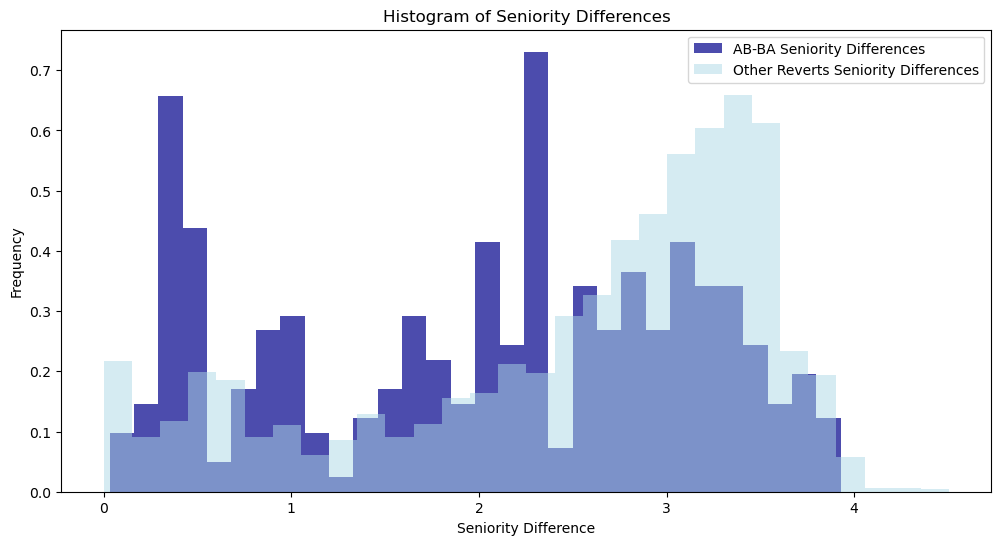

Mean Seniority Difference in AB-BA Sequences: 2.0315392120456877
Mean Seniority Difference in Other Reverts: 2.5240936850849276


In [3]:
# Get absolute seniority difference for reverts in AB-BA sequences and the rest

# Plot a histogram with the two distributions overlapping

# Print the mean abs. seniority diff. for reverts in AB-BA sequences and the rest

from data_manipulation import plot_seniority_diff_histogram
from revert_network import calculate_seniority_diffs
import numpy as np

# Calculate seniority differences in AB-BA sequences
ab_ba_seniority_diffs, other_reverts_seniority_diffs = calculate_seniority_diffs(network_with_seniortiy, ab_ba_sequences)

# Plot the histogram, use"density=True" makes the histogram show proportions
plot_seniority_diff_histogram(ab_ba_seniority_diffs, other_reverts_seniority_diffs)

# print the mean seniority differences
mean_ab_ba_diff = np.mean(ab_ba_seniority_diffs)
mean_other_diff = np.mean(other_reverts_seniority_diffs)

print(f"Mean Seniority Difference in AB-BA Sequences: {mean_ab_ba_diff}")
print(f"Mean Seniority Difference in Other Reverts: {mean_other_diff}")


---

### Evaluation

| Aspect         | Mark     | Comment   
|:--------------:|:--------:|:----------------------
| Code runs      |   /10    |              
| 1, network     |   /10    | 
| 1, seniority   |   /10    | 
| 2              |   /10    | 
| 3              |   /10    | 
| Legibility     |   /10    | 
| Modularity     |   /10    | 
| Optimization   |   /30    | 
| **Total**      |**/100**  | 